In [25]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload

import datetime as dt
import pandas as pd
os.chdir("../from_config") ######!!!!!!
import dev.datawhere as dl
graph_data=dl.graph_data

Notebook
GPU detected


In [26]:
os.chdir('../model_eval')
os.getcwd()

'C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube\\model_eval'

In [27]:
def get_sets():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/MuonGun/sets.pkl')
#         train_events = sets['train']
#         test_events = sets['test']
        return sets
sets=get_sets()

Reading sets


In [28]:
def get_sets():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/dev_lvl7/sets.pkl')
        train_events = sets['train']
        test_events = sets['test']
        return train_events['event_no'].to_numpy(), test_events['event_no'].to_numpy()
_, test_events=get_sets()

Reading sets


In [29]:
no, cos= np.unique(test_events, return_counts=True)

In [6]:
# with tf.device('/cpu:0'):
#     save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
#     model=tf.keras.models.load_model("../trained_models/IceCube_neutrino/KHop_K[1,2]agmaxn_25_2htf2yxw", options=save_options)
# model.compile()
# batch_size=512
# # dataset=graph_data(test_steps=10, n_neighbors=25, restart=False, \
# #                                      transform_path='../db_files/dev_lvl7//transformers.pkl')
# # loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [30]:
with tf.device('/cpu:0'):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model=tf.keras.models.load_model("../from_config/trained_models/IceCube_neutrino/KHop_K[2]agprodn_25_yuef885p", options=save_options)
model.compile()
batch_size=512

In [31]:
def predict(loader):
    prediction_list, target_list = [], []
    for batch in tqdm(loader, total=loader.steps_per_epoch):
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)

        prediction_list.append(predictions.numpy())
        target_list.append(targets.numpy())
        y_reco  = tf.concat(prediction_list, axis = 0).numpy()
        y_true  = tf.concat(target_list, axis = 0).numpy()
#         y_true  = tf.cast(y_true, tf.float32).numpy()
    return y_reco, y_true

In [33]:
os.chdir('C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor/IceCube')
recos=[]
trues=[]
evnos=[]
batch_size=512
for i in range(10):
    dataset=graph_data(n_steps=10, n_neighbors=35, restart=False, traintest='test', i_test=i)
    loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1, shuffle=True)
    @tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
    def test_step(inputs, targets):
        predictions = model(inputs, training = False)
#             targets     = tf.cast(targets, tf.float32) 

        return predictions, targets
    reco, true=predict(loader)
    recos.append(reco)
    trues.append(true)
os.chdir('model_eval')

Loading test data 0 to memory



Loading test data 1 to memory



Loading test data 2 to memory



Loading test data 3 to memory



Loading test data 4 to memory



Loading test data 5 to memory



Loading test data 6 to memory



Loading test data 7 to memory



Loading test data 8 to memory



Loading test data 9 to memory


In [37]:
predckj=np.concatenate(recos)
trueckj=np.concatenate(trues)
# predckj=0
# trueckj=0
# dataset=0

In [38]:
import pandas as pd
predl=['energy_log10_pred', 'zenith_pred', 'azimuth_pred', 'zenith_kappa', 'azimuth_kappa']
truel=['energy_log10', 'zenith', 'azimuth', 'event_no']
dfckj1=pd.DataFrame(np.hstack([trueckj,predckj]), columns=truel+predl)

In [39]:
dfckj1.sort_values(by='event_no', inplace=True)

In [48]:
dfckj=pd.read_csv('../predictions/ckj_2dvM_0906.csv')

In [64]:
dfckj['energy_log10_pred']=dfckj1['energy_log10_pred'].to_numpy()

<AxesSubplot:>

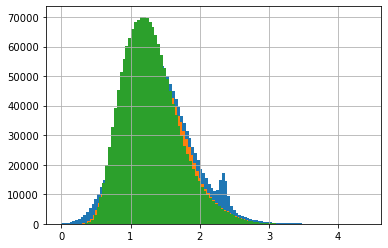

In [72]:
dfckj['energy_log10'].hist(bins=100)
dfckj['energy_log10_pred'].hist(bins=100)

In [122]:
w=np.percentile(180/np.pi*abs(dfckj['zenith_pred']-dfckj['zenith']), 75)-np.percentile(180/np.pi*abs(dfckj['zenith_pred']-dfckj['zenith']), 25)
w/1.349

13.074621276013334

In [128]:
bins=10
res=(180/np.pi*abs(dfckj['zenith_pred']-dfckj['zenith']).to_numpy())
x=dfckj['energy_log10'].to_numpy()
slices = np.linspace(x.min(),x.max(),bins + 1)
iqr=[]
xs=[]
for i in range(bins):
    mask = (x >= slices[i])&(x <= slices[i+1])
    iqr.append((np.percentile(res[mask],75)-np.percentile(res[mask],25))/1.349)
    xs.append(np.mean(x[mask]))

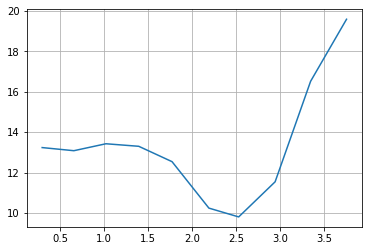

In [130]:
plt.plot(xs, iqr)
plt.grid(True)

In [98]:
dfckj.rename(columns={'zenith_kappa': 'azimuth_kap'}, inplace=True)
dfckj.rename(columns={'azimuth_kappa': 'zenith_kap'}, inplace=True)

<ipython-input-84-827de795701d>:11: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, abs(np.sqrt(-2*np.log(approx(kappa)))), abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))))


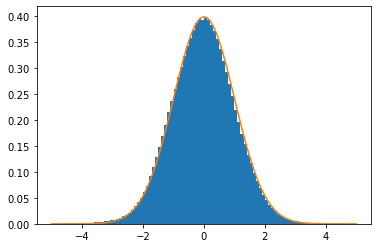

In [121]:
from scipy.stats import norm
_,bins,_=plt.hist((dfckj['zenith_pred']-dfckj['zenith'])/(kap_to_sig(dfckj['zenith_kap'])), bins=100, range=(-5,5), density=1)
plt.plot(bins, norm.pdf(bins,0,1))

<ipython-input-84-827de795701d>:11: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, abs(np.sqrt(-2*np.log(approx(kappa)))), abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))))


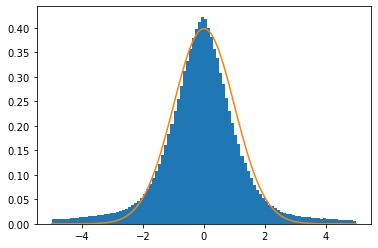

In [118]:
from scipy.stats import norm
_,bins,_=plt.hist((dfckj['azimuth_pred']-dfckj['azimuth'])/(kap_to_sig(dfckj['azimuth_kap']/4.1)), bins=100, range=(-5,5), density=1)
plt.plot(bins, norm.pdf(bins,0,1))

In [120]:
dfckj.to_csv('../predictions/ckj_2dvM_1306_final.csv')

In [17]:
# from scipy.special import iv
# ze_sigma = np.sqrt(1 - iv(1,np.square(reco[:,3]))/iv(0,np.square(reco[:,3])))*180/np.pi
# az_sigma = np.sqrt(1 - iv(1,np.square(reco[:,4]))/iv(0,np.square(reco[:,4]))*180/np.pi
# zenimask=reco[:,3]>np.median(reco[:,3])
# azimask=reco[:,4]>np.median(reco[:,4])
# zenireco, zenitrue=reco[zenimask], true[zenimask]
# azireco, azitrue=reco[azimask], true[azimask]
# mask=np.logical_and(zenimask, azimask) 
# reco1, true1=reco[mask], true[mask]

In [18]:
dfras_zenith=pd.read_csv('../predictions/rasmus_zenith.csv')
dfras_azimuth=pd.read_csv('../predictions/rasmus_azimuth.csv')
dfras_energy=pd.read_csv('../predictions/rasmus_energy.csv')

In [19]:
dfras=dfras_zenith.merge(dfras_azimuth, on='event_no', how='left')
dfras=dfras.merge(dfras_energy, on='event_no', how='left')

In [20]:
for col in dfras.columns:
    if 'dir' in col:
        dfras=dfras.drop(col, axis=1)
        
for col in dfras.columns:
    if '_y' in col:
        dfras=dfras.drop(col, axis=1)
        
for col in dfras.columns:  
    if '_x' in col:
        dfras[col[:-2]]=dfras[col].to_numpy()
        dfras=dfras.drop(col, axis=1)

In [21]:
dfrasna=dfras.dropna(axis=0)

In [22]:
dfras=dfras.drop(['azimuth_pred', 'azimuth_pred_k', 'energy_log10_pred', 'Unnamed: 0'], axis=1)

In [23]:
transform_path='../db_files/dev_lvl7/transformers.pkl'
import pickle
transformers = pickle.load(open(transform_path, 'rb'))
trans_y      = transformers['truth']
tcols=['energy_log10', 'zenith', 'azimuth']
cols=dfrasna.columns
for col in cols:
    for tcol in tcols: 
        if tcol in col:
            dfrasna[tcol] = trans_y[tcol].inverse_transform(np.array(dfrasna[tcol]).reshape(1, -1)).T
            dfrasna[tcol+'_pred'] = trans_y[tcol].inverse_transform(np.array(dfrasna[tcol+'_pred']).reshape(1, -1)).T
            
cols=dfras.columns
for col in cols:
    for tcol in tcols: 
        if tcol==col:
            dfras[tcol] = trans_y[tcol].inverse_transform(np.array(dfras[tcol]).reshape(1, -1)).T
            if tcol=='zenith':
                dfras[tcol+'_pred'] = trans_y[tcol].inverse_transform(np.array(dfras[tcol+'_pred']).reshape(1, -1)).T

In [11]:
dfjv=pd.read_csv('../predictions/jv_0406.csv')
dfckj=pd.read_csv('../predictions/ckj_2dvM_0206.csv')
dfjs=pd.read_csv('../predictions/jakob_predictions_0106_2.csv')
dfjbs=pd.read_csv('../predictions/GraphSageFullOscNext.csv')
# dfjbs=pd.read_csv('../predictions/GraphSageFullOscNext_3D.csv')
dfstats=pd.read_csv('../predictions/stats.csv')
dfjbs['zenith']=np.pi-dfjbs['zenith']
dfjbs['zenith_pred']=np.pi-dfjbs['zenith_pred']
dfjs.rename(columns={'zenith_pred_sigma': 'zenith_kap'}, inplace=True)
dfckj.rename(columns={'zenith_kappa': 'zenith_kap'}, inplace=True)
dfckj.rename(columns={'azimuth_kappa': 'azimuth_kap'}, inplace=True)

In [12]:
dfjs=dfjs.drop(0)
dfckj=dfckj.sort_values(by='event_no')
dfjv=dfjv.sort_values(by='event_no')
dfjs=dfjs.sort_values(by='event_no')
dfjbs=dfjbs.sort_values(by='event_no')
dfstats=dfstats.sort_values(by='event_no')

NameError: name 'dfras' is not defined

In [16]:
np.percentile(abs(dfckj['zenith_res'])*180/np.pi,[50])

array([9.55187022])

In [ ]:
# dfjs['energy_log10_pred']=dfjs['energy_log10']

In [ ]:
# dfjs['zenith']=dfckj['zenith'].to_numpy()
# dfjs['energy_log10']=dfckj['energy_log10'].to_numpy()

In [ ]:
mask=dfckj['event_no'].to_numpy()==dfjbs['event_no'].to_numpy()

In [ ]:
dfstats=dfstats[mask]

In [ ]:
dfs0=[dfjv[mask], dfckj[mask], dfjs[mask], dfjbs[mask]]
names=['Jonas', 'Christian', 'Schauser', 'Johann']

In [ ]:
# maskras=np.in1d(dfs0[0].event_no.to_numpy(), dfras.event_no.to_numpy())
# maskinvras=np.in1d(dfras.event_no.to_numpy(), dfs0[0].event_no.to_numpy())
# dfs=[df[maskras] for df in dfs0]
# dfs.append(dfras[maskinvras])
# names=['Jonas', 'Christian', 'Schauser', 'Johann', "DynEdge"]

In [ ]:
dfs=[]
for df in dfs0:
#     df=df[mask]
    for target in truel[:3]:
        if target not in df.columns:
            df[target]=dfs0[3][target].to_numpy()
        if target+'_pred' in df.columns:
            df[target+'_res']=df[target]-df[target+'_pred']
    dfs.append(df)

In [ ]:
# col='energy_log10'
# col='zenith'
# for df in dfs:
#     print(sum(np.isclose(df[col].to_numpy(),dfs[0][col].to_numpy(), rtol=1e-1))/len(dfs[0]['energy_log10']))

In [ ]:
col='zenith'
mask1=np.isclose(dfs[1][col].to_numpy(),dfs[0][col].to_numpy(), rtol=1e-4)
dfs0=dfs
dfs=[]
for df in dfs0:
    dfs.append(df[mask1])

In [ ]:
dfstats=dfstats[mask1]

In [ ]:
# col='energy_log10'
# # col='zenith'
# for df in dfs:
#     print(sum(np.isclose(df[col].to_numpy(),dfs[0][col].to_numpy(), rtol=1e-1))/len(dfs[0]['energy_log10']))

In [ ]:
import sqlite3, os, sys, pickle
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
transform_path='../db_files/dev_lvl7/transformers.pkl'
db_path= '../db_files/dev_lvl7/dev_lvl7_mu_nu_e_classification_v003.db'
conn = sqlite3.connect(db_path)
def get_event_no():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/dev_lvl7/sets.pkl')
        train_events = sets['train']
        test_events = sets['test']
        return train_events['event_no'].to_numpy(), test_events['event_no'].to_numpy()
_, test_events=get_event_no()
df_truth=pd.read_sql(f"select * from truth where event_no in {tuple(test_events)}", conn)
cols=df_truth.columns

In [ ]:
df_truth.zenith.hist(bins=200)

In [ ]:
transformers = pickle.load(open(transform_path, 'rb'))
trans_y      = transformers['truth']

for col in truel[:3]:
    df_truth[col] = trans_y[col].inverse_transform(np.array(df_truth[col]).reshape(1, -1)).T

In [8]:
df_truth.zenith.hist(bins=200)

NameError: name 'df_truth' is not defined

In [9]:
df_truth=df_truth.sort_values(by='event_no')
df_truth=df_truth[mask]
df_truth=df_truth[mask1]
for col in cols:
    if 'position' in col:
        df_truth.drop(col, axis=1, inplace=True)

NameError: name 'df_truth' is not defined

In [10]:
df_truth.zenith.hist(bins=200)

NameError: name 'df_truth' is not defined

In [43]:
new=['event_no', 'energy_log10', 'azimuth', 'zenith', 'azimuth_pred', 'energy_log10_pred',
       'zenith_pred', 'azimuth_sig', 'zenith_sig', 'energy_log10_sig']
sel=['event_no', 'energy_log10', 'azimuth', 'zenith',  'azimuth_retro', 'energy_log10_retro',
       'zenith_retro', 'azimuth_sigma', 'zenith_sigma', 'energy_log10_sigma']

In [44]:
dfretro=pd.DataFrame(df_truth[sel].to_numpy(), columns=new)
for target in truel[:3]:
    if target+'_pred' in df.columns:
        dfretro[target+'_res']=dfretro[target]-dfretro[target+'_pred']
dfs.append(dfretro)

In [45]:
names.append('Retro')

In [84]:
from scipy.special import iv

def approx(x):
    x=np.array(x)
    a=1-3/(8*x)
    b=1+1/(8*x)
    return a/b

def kap_to_sig(kappa):
    kappa = kappa + 1e-5
    sigs=np.where(kappa>700, abs(np.sqrt(-2*np.log(approx(kappa)))), abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))))
    return sigs

sigs=kap_to_sig(np.arange(0,100,20))

<ipython-input-84-827de795701d>:11: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, abs(np.sqrt(-2*np.log(approx(kappa)))), abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))))


In [48]:
sigs

array([2.22280562, 0.2236768 , 0.15811697, 0.12910057, 0.11180394])

In [49]:
from scipy.special import iv
def kap_to_sig2(kappa):
    kappa =  abs(kappa)+ 1e-5
    return np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))), (iv(1,kappa)/iv(0,kappa)), iv(1,kappa),iv(0,kappa)

In [50]:
x, y =[],[]
for i in range(200, 700, 5):
#     print(i, kap_to_sig2(i))
    x.append(i)
    _, c, _,_=kap_to_sig2(i)
    y.append(c)

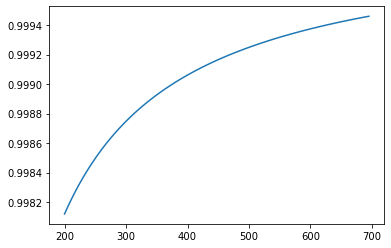

In [51]:
# plt.plot(x, np.log(y))
# plt.plot(x,np.log(approx(x)))
plt.plot(x,np.log(approx(x))/np.log(y))

In [52]:
sigs=kap_to_sig(np.arange(0,1000,20))

<ipython-input-47-99e2d479891a>:4: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))
<ipython-input-47-99e2d479891a>:4: RuntimeWarning: invalid value encountered in true_divide
  sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))


In [53]:
# def kap_to_sig_ckj(kappa):
#     kappa =  kappa**2 + 1e-5
#     return np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))

In [54]:
dfs_ka=[]
for name,df in zip(names, dfs):
    for target in truel:
        if target+'_kap' in df.columns:
                df[target+'_sig']=kap_to_sig(df[target+'_kap'].to_numpy())
    if 'zenith_sig' in df.columns:
        dfs_ka.append(df)

<ipython-input-47-99e2d479891a>:4: RuntimeWarning: invalid value encountered in log
  sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))
<ipython-input-47-99e2d479891a>:4: RuntimeWarning: invalid value encountered in true_divide
  sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))
<ipython-input-54-ec8a4a0d0efe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target+'_sig']=kap_to_sig(df[target+'_kap'].to_numpy())


In [55]:
dfs_ka.append(dfretro)

NameError: name 'dfs_ka' is not defined

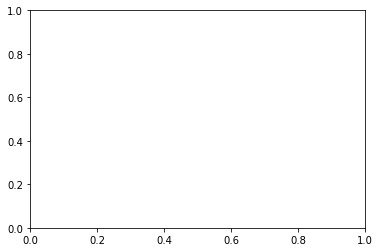

In [3]:
from scipy.stats import norm
facts=[1.06,3/10,1, 2]
for k in range(4):
    fig, ax =plt.subplots()
    _, bins, _ = ax.hist(dfs_ka[k].zenith_res/(facts[k]*dfs_ka[k].zenith_sig), bins=100, range=(-10,10), density=1, alpha=0.5)
    ax.plot(bins, norm.pdf(bins,0,1))
    ax.set(xlabel=names[k])

In [57]:
def perms(val):
    perm=[]
    for i in range(val):
        for j in range(i, val):
            if i!=j:
                perm.append(np.array([i,j]))
    return np.array(perm)

In [58]:
def corr_plot(dfs, param, names=names, lim=2, basesize=5, bins=200, nr=2, nc=3):
    fig, ax =plt.subplots(nrows=nr, ncols=nc, figsize=(basesize*nc,basesize*nr))
    perm=perms(len(dfs))
    if len(perm)!=nr*nc:
        print(f"Ax doesn't fit dataframe, supposed to be {len(perm)} in total")
    k=0
    for i in range(nr):
        for j in range(nc):
            p=perm[k]
            ax[i][j].hist2d(dfs[p[0]][param+'_res'], dfs[p[1]][param+'_res'], range=[[-lim,lim],[-lim,lim]], bins=bins)
            ax[i][j].set(xlabel=names[p[0]], ylabel=names[p[1]])
            k+=1
    fig.suptitle(f"Comparison of {param}")
    fig.tight_layout()
    return fig, ax

(<Figure size 1440x576 with 10 Axes>,
 array([[<AxesSubplot:xlabel='Jonas', ylabel='Christian'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Johann'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Retro'>,
         <AxesSubplot:xlabel='Christian', ylabel='Schauser'>],
        [<AxesSubplot:xlabel='Christian', ylabel='Johann'>,
         <AxesSubplot:xlabel='Christian', ylabel='Retro'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Johann'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Retro'>,
         <AxesSubplot:xlabel='Johann', ylabel='Retro'>]], dtype=object))

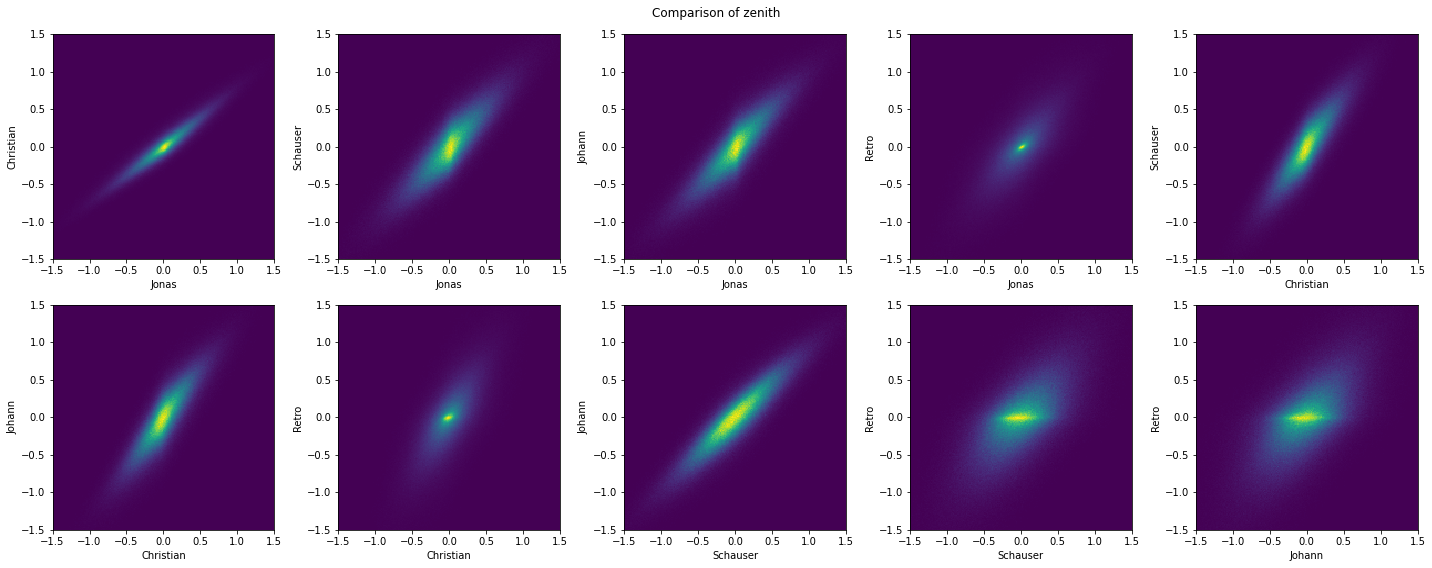

In [59]:
corr_plot(dfs, 'zenith', nc=5, nr=2, basesize=4, lim=1.5)

(<Figure size 1440x576 with 10 Axes>,
 array([[<AxesSubplot:xlabel='Jonas', ylabel='Christian'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Johann'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Retro'>,
         <AxesSubplot:xlabel='Christian', ylabel='Schauser'>],
        [<AxesSubplot:xlabel='Christian', ylabel='Johann'>,
         <AxesSubplot:xlabel='Christian', ylabel='Retro'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Johann'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Retro'>,
         <AxesSubplot:xlabel='Johann', ylabel='Retro'>]], dtype=object))

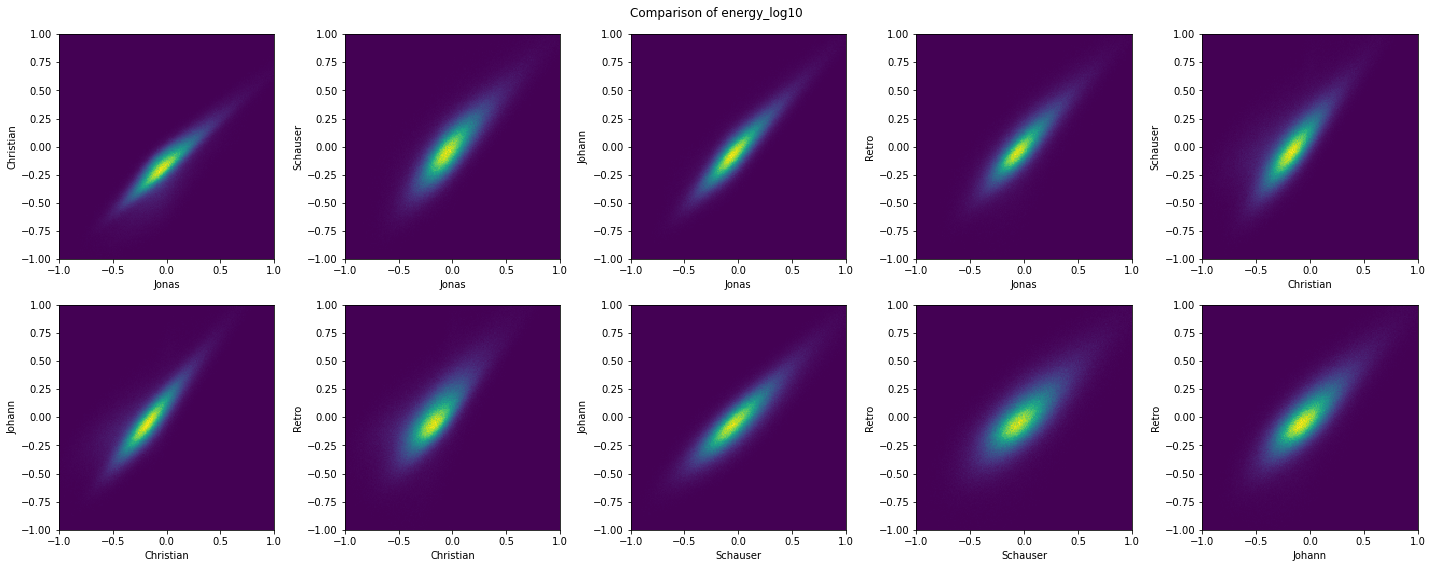

In [60]:
corr_plot(dfs, 'energy_log10', nc=5, nr=2, basesize=4, lim=1)

(<Figure size 1080x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Jonas', ylabel='Christian'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Jonas', ylabel='Johann'>],
        [<AxesSubplot:xlabel='Christian', ylabel='Schauser'>,
         <AxesSubplot:xlabel='Christian', ylabel='Johann'>,
         <AxesSubplot:xlabel='Schauser', ylabel='Johann'>]], dtype=object))

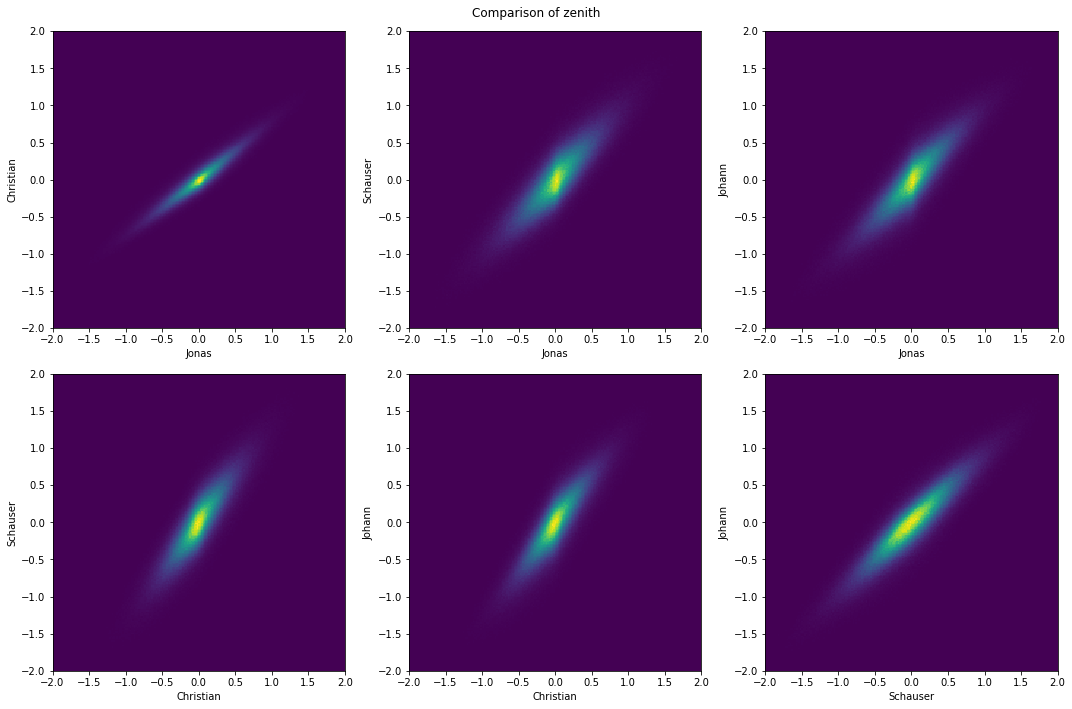

In [61]:
corr_plot(dfs[:4], 'zenith')

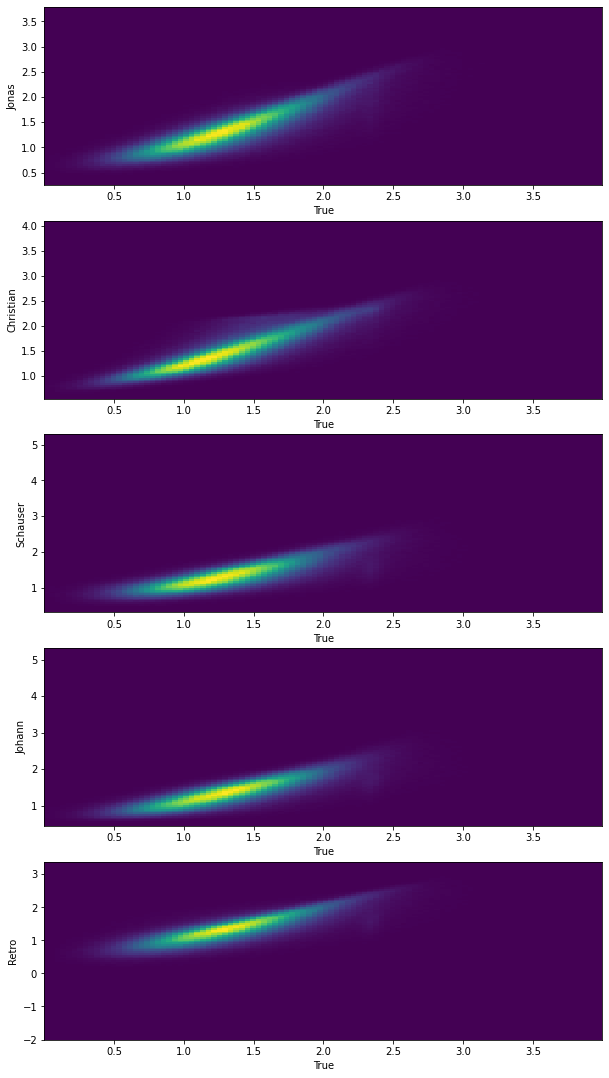

In [62]:
fig, ax =plt.subplots(nrows=5, figsize=(10,19))
for i in range(5):
    ax[i].hist2d(df_truth['energy_log10'], dfs[i]['energy_log10_pred'], bins=100)
    ax[i].set(xlabel='True', ylabel=names[i])

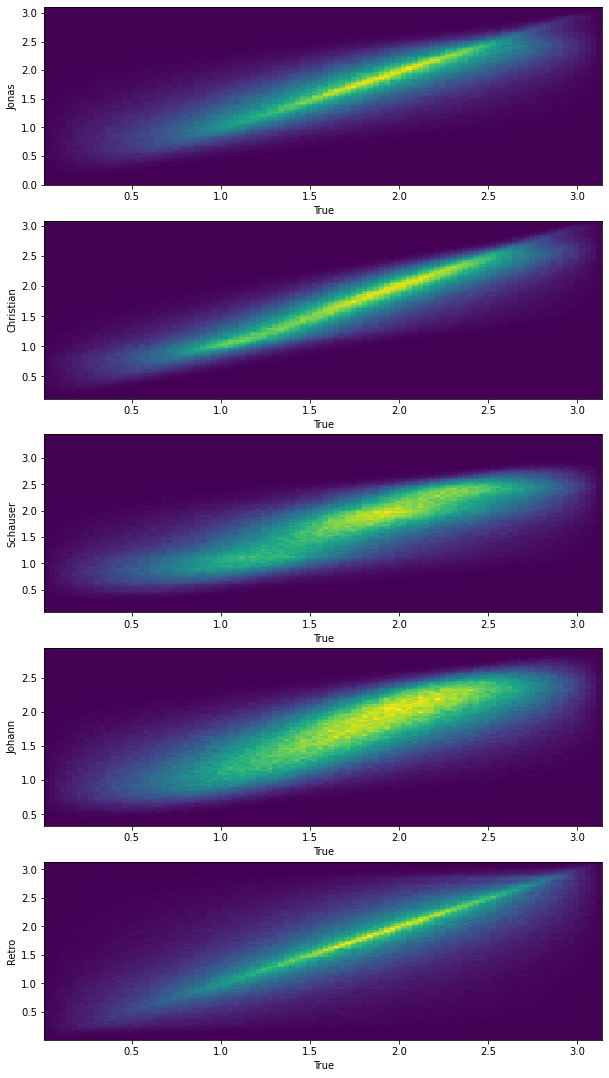

In [63]:
fig, ax =plt.subplots(nrows=5, figsize=(10,19))
for i in range(5):
    ax[i].hist2d(df_truth['zenith'], dfs[i]['zenith_pred'], bins=100)
    ax[i].set(xlabel='True', ylabel=names[i])

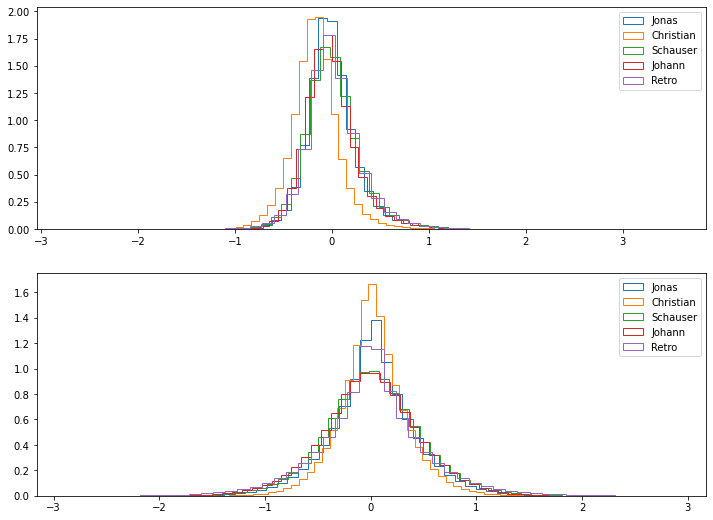

In [64]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
dens=1
for i in range(5):
    ax[0].hist(dfs[i]['energy_log10_res'], bins=bins, histtype='step',  density=dens, label=names[i])
    ax[1].hist(dfs[i]['zenith_res'], bins=bins, histtype='step',  density=dens, label=names[i])
    
# ax[0].hist(df_truth['energy_log10']-df_truth['energy_log10_retro'], bins=bins, histtype='step',  density=dens, label='Retro')
# ax[1].hist(df_truth['zenith']-df_truth['zenith_retro'], bins=bins, histtype='step',  density=dens, label='Retro')

ax[0].legend()
ax[1].legend()

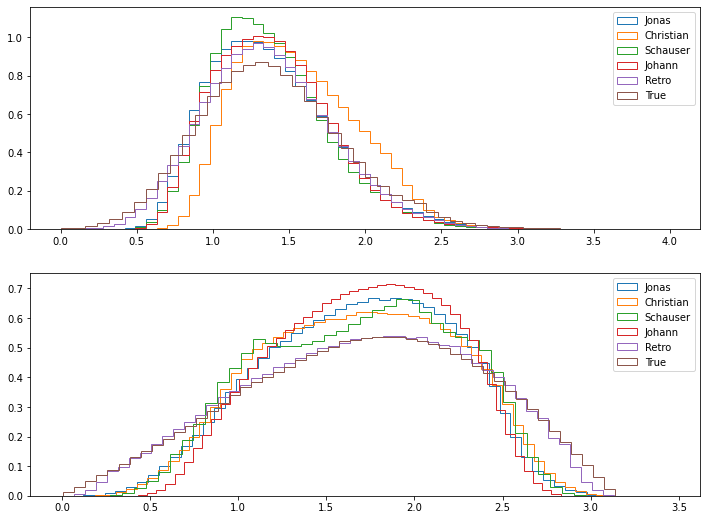

In [65]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
dens=1
for i in range(5):
    ax[0].hist(dfs[i]['energy_log10_pred'], bins=bins, range=(0,3.5), histtype='step',  density=dens, label=names[i])
    ax[1].hist(dfs[i]['zenith_pred'], bins=bins, histtype='step',  density=dens, label=names[i])
ax[0].hist(df_truth['energy_log10'], bins=bins, histtype='step',  density=dens, label='True')
ax[1].hist(df_truth['zenith'], bins=bins, histtype='step',  density=dens, label='True')
ax[0].legend()
ax[1].legend()

In [66]:
dfstats

Unnamed: 0   event_no  n_strings  n_doms        cq_x        cq_y  \
0                 0          8        7.0      11   29.560598  -28.549552   
1                 1         10        7.0      16   60.860462  -58.746769   
2                 2         15        5.0      17   33.878788  -11.369393   
3                 3         29        3.0       9  103.089133  -87.221304   
4                 4         32        3.0      18   -2.941875  -80.715625   
...             ...        ...        ...     ...         ...         ...   
1658266     1658266  117104280        7.0      16   25.476153   30.214153   
1658295     1658295  117104410        4.0      19   92.061704  -17.235106   
1658296     1658296  117104424        6.0      21   49.674525 -111.003095   
1658337     1658337  117104650        8.0      19  -16.869273  -78.887637   
1658348     1658348  117104696        6.0      16   40.553039  -66.385443   

               cq_z  
0       -346.532387  
1       -388.543386  
2       -323.135152  
3       -439.446528  
4       -303.853742  
...             ...  
1658266 -319.356001  
1658295 -212.125110  
1658296 -230.398335  
1658337 -293.396635  
1658348 -296.295820  

[1633027 rows x 7 columns]

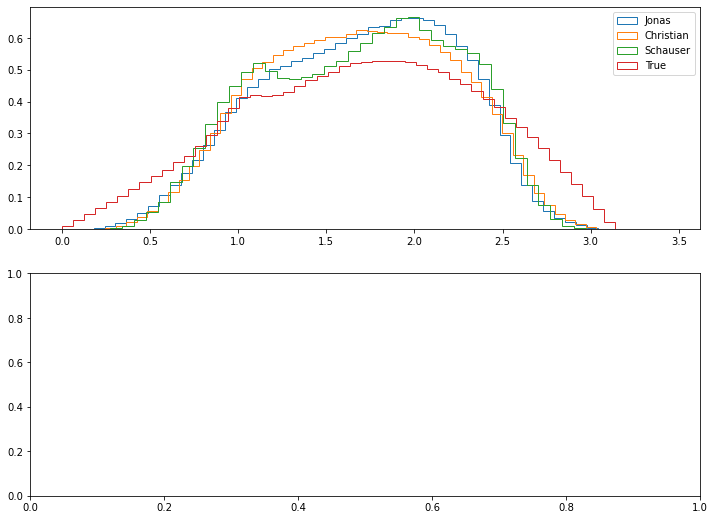

In [67]:
fig, ax=plt.subplots(2, figsize=(12,9))
bins=50
dens=1
for df,name in zip(dfs_ka[:3], names[:3]):
    ax[0].hist(df['zenith_pred'][(df['zenith_sig'] < np.percentile(df['zenith_sig'], 95))], bins=bins, histtype='step', label=name, density=dens)
ax[0].hist(dfckj['zenith'], bins=bins, histtype='step',  density=dens, label='True')
ax[0].legend()

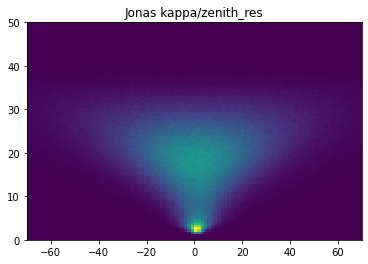

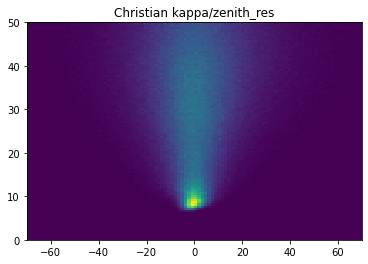

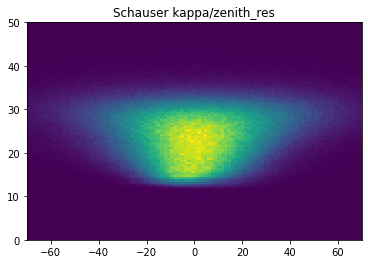

In [68]:
p=100
n=2
for n in range(3):
    fig, ax=plt.subplots()
    ax.hist2d((dfs[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], p))].zenith_res*180/np.pi)\
              , dfs_ka[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], p))].zenith_sig*180/np.pi,\
              bins=100, range=[[-70,70],[0,50]]);
    ax.set(title=names[n]+' kappa/zenith_res')

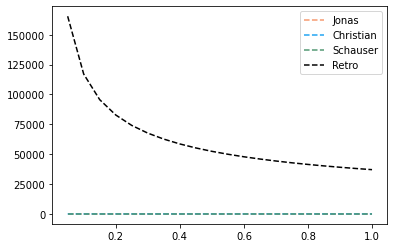

In [142]:
# n=2
facts=[1.06, 0.4, 1, 1]
for n in [0,1,2,3]:
    sig_run=[]
    for i in range(1,21):
        df_per=dfs_ka[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], i*5))]
        st=np.std(df_per['zenith_res']/(df_per['zenith_sig']*facts[n]+0.000001))
#         print(st)
        sig_run.append(st)
    if n==3:
        n+=1
    plt.plot(np.arange(1,21)/20, sig_run, label=names[n], c=colors[n], linestyle='dashed')
plt.legend()

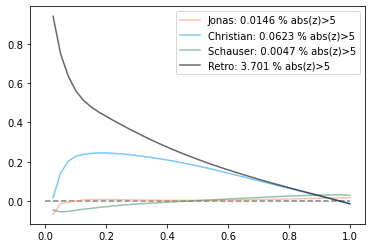

In [155]:
k=40
facts=[1.06, 0.4, 1, 2]
for n in [0,1,2, 3]:
    sig_run=[]
    for i in range(1,k+1):
        df_per=dfs_ka[n][(dfs_ka[n]['zenith_sig'] < np.percentile(dfs_ka[n]['zenith_sig'], i*2.5))]
        if i==k:
            a=len(df_per)
        df_per=df_per[abs(df_per['zenith_res']/(df_per['zenith_sig']*facts[n]+0.000001))<5]
        if i==k:
            b=len(df_per)
            c=a-b
        st=np.std(df_per['zenith_res']/(df_per['zenith_sig']*facts[n]+0.000001))
#         print(st)
        sig_run.append(st)
    if n==3:
        n+=1
    
    plt.plot(np.arange(1,k+1)/k, np.log(sig_run), label=names[n]+f': {np.round(c/a*100, 4)} % abs(z)>5', c=colors[n], linestyle='-', alpha=0.6)
plt.hlines(0,0,1, linestyle='dashed', color='gray')
plt.legend()

In [69]:
k=2
np.percentile(dfs[k]['zenith_sig'], 50)

0.43032088787415146

In [70]:
dfs_ka[k].describe()

Unnamed: 0      event_no  energy_log10  energy_log10_pred  \
count  1.633027e+06  1.633027e+06  1.633027e+06       1.633027e+06   
mean   8.292034e+05  6.838142e+06  1.383190e+00       1.367347e+00   
std    4.787434e+05  4.936352e+06  4.730510e-01       3.706447e-01   
min    1.000000e+00  8.000000e+00  5.581535e-05       3.132948e-01   
25%    4.146005e+05  3.433202e+06  1.052147e+00       1.095444e+00   
50%    8.292340e+05  6.867563e+06  1.352626e+00       1.324560e+00   
75%    1.243862e+06  1.026266e+07  1.677530e+00       1.591662e+00   
max    1.658362e+06  1.171047e+08  3.997173e+00       5.283747e+00   

             zenith   zenith_pred    zenith_kap  energy_log10_res  \
count  1.633027e+06  1.633027e+06  1.633027e+06      1.633027e+06   
mean   1.710938e+00  1.691082e+00  6.621666e+00      1.584300e-02   
std    6.614248e-01  5.336108e-01  3.563810e+00      2.889600e-01   
min    7.919154e-03  7.108688e-02  5.997890e-02     -2.251434e+00   
25%    1.227602e+00  1.259685e+00  4.046726e+00     -1.645943e-01   
50%    1.741449e+00  1.723782e+00  5.447040e+00     -1.032957e-02   
75%    2.219668e+00  2.116480e+00  8.145241e+00      1.649945e-01   
max    3.140002e+00  3.446488e+00  3.876534e+01      2.822831e+00   

         zenith_res       azimuth    zenith_sig  
count  1.633027e+06  1.633027e+06  1.633027e+06  
mean   1.985595e-02  1.105748e-02  4.273600e-01  
std    4.570937e-01  1.816777e+00  9.937942e-02  
min   -2.418280e+00 -3.141591e+00  1.606154e-01  
25%   -2.604917e-01 -1.561092e+00  3.510546e-01  
50%    1.210463e-02  1.739317e-02  4.303209e-01  
75%    2.967789e-01  1.588990e+00  5.010837e-01  
max    2.382580e+00  3.141592e+00  1.885388e+00

In [71]:
k=1
dfs_ka[k]['zenith_sig'].isnull().sum()

0

<AxesSubplot:>

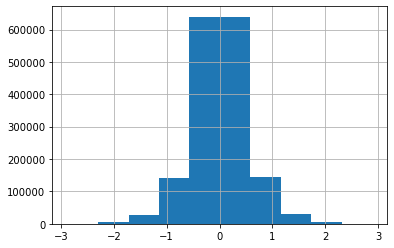

In [132]:
dfretro['zenith_res'].hist()

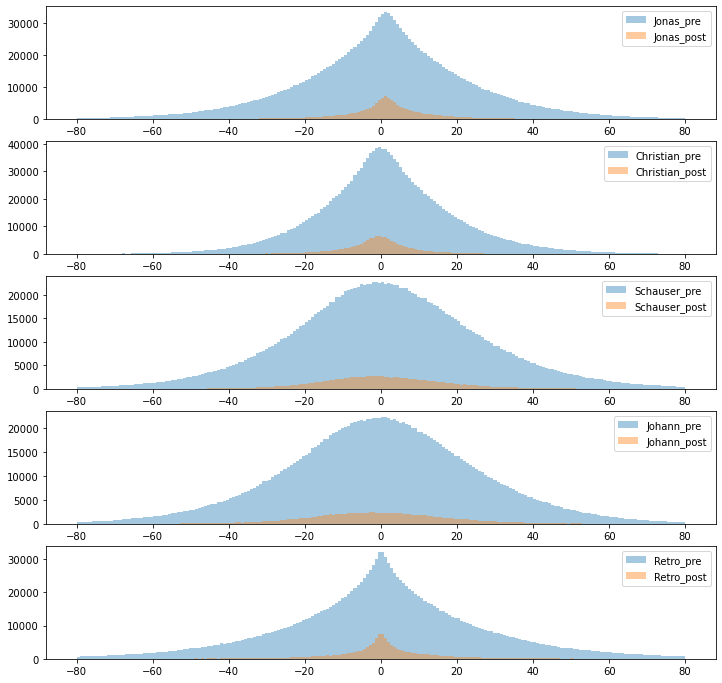

In [73]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=0
ran=[-80,80]
for i in range(5):
    ax[i].hist(dfs[i][dfstats['n_strings'].to_numpy()>0].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, range=ran, label=names[i]+'_pre');
    ax[i].hist(dfs[i][dfstats['n_strings'].to_numpy()>10].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, range=ran, label=names[i]+'_post');
    ax[i].legend()

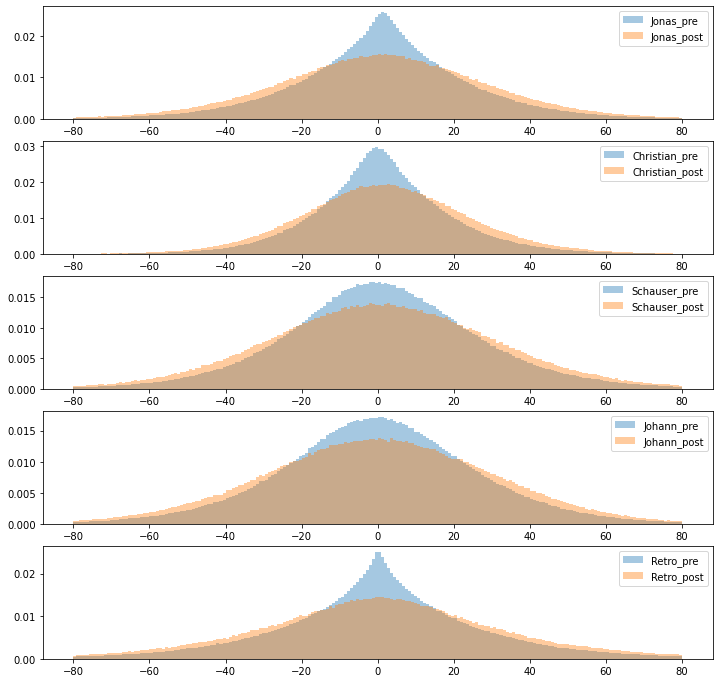

In [74]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=1
for i in range(5):
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()>0].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_pre');
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()<15].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_post');
    ax[i].legend()

Text(0.5, 0.98, 'Distributions for more than median #doms compared to normal')

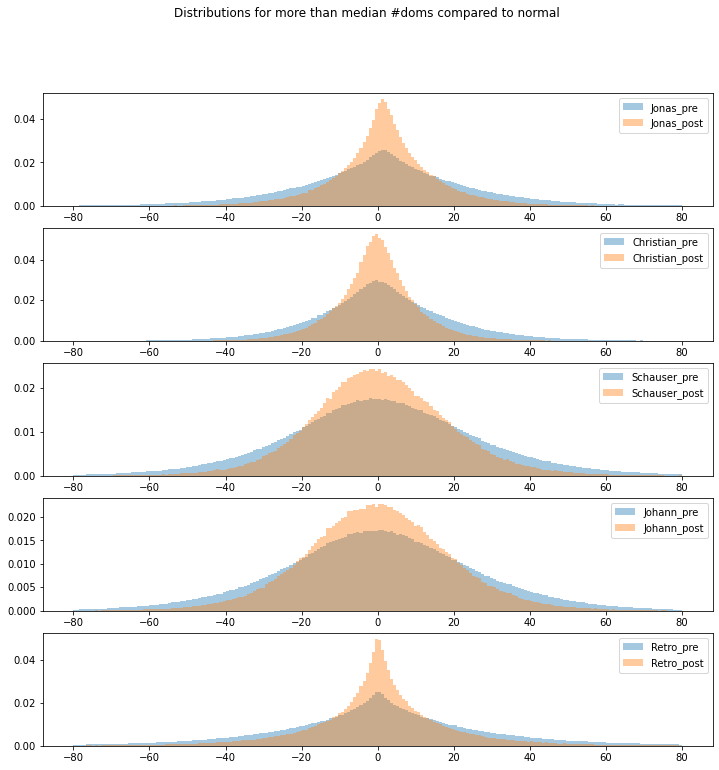

In [75]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=1
for i in range(5):
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()>0].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_pre');
    ax[i].hist(dfs[i][dfstats['n_doms'].to_numpy()>28].zenith_res*180/np.pi, alpha=0.4, bins=bi, range=ran, density=dens, label=names[i]+'_post');
    ax[i].legend()
fig.suptitle('Distributions for more than median #doms compared to normal')

Text(0.5, 0.98, 'Distributions selected at -400 z compared to usual')

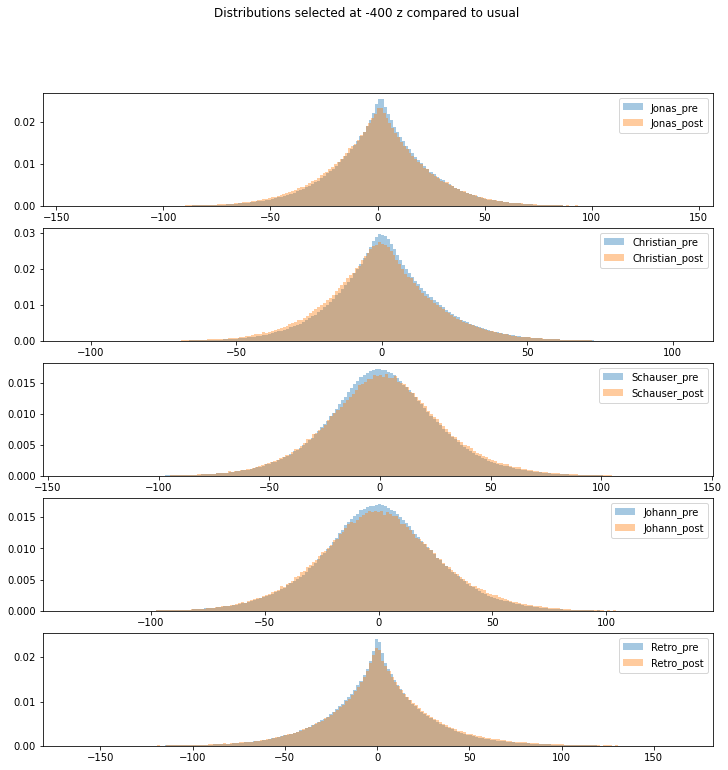

In [76]:
fig, ax=plt.subplots(5, figsize=(12,12))
bi=200
dens=1
for i in range(5):
    ax[i].hist(dfs[i].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, label=names[i]+'_pre');
    ax[i].hist(dfs[i][abs(dfstats['cq_z'].to_numpy())>400].zenith_res*180/np.pi, alpha=0.4, bins=bi, density=dens, label=names[i]+'_post');
    ax[i].legend()
fig.suptitle('Distributions selected at -400 z compared to usual')

<AxesSubplot:>

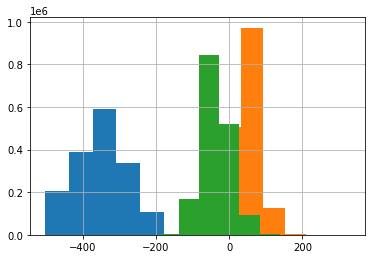

In [77]:
dfstats['cq_z'].hist()
dfstats['cq_x'].hist()
dfstats['cq_y'].hist()

In [78]:
dfstats.describe()

Unnamed: 0      event_no     n_strings        n_doms          cq_x  \
count  1.633027e+06  1.633027e+06  1.633027e+06  1.633027e+06  1.633027e+06   
mean   8.165512e+05  6.838142e+06  6.289399e+00  2.631399e+01  4.839361e+01   
std    4.714615e+05  4.936352e+06  2.801720e+00  2.976155e+01  3.292516e+01   
min    0.000000e+00  8.000000e+00  1.000000e+00  8.000000e+00 -2.626905e+02   
25%    4.082655e+05  3.433202e+06  4.000000e+00  1.200000e+01  2.642358e+01   
50%    8.165310e+05  6.867563e+06  6.000000e+00  1.700000e+01  4.851335e+01   
75%    1.224794e+06  1.026266e+07  8.000000e+00  2.800000e+01  7.044698e+01   
max    1.658348e+06  1.171047e+08  3.000000e+01  1.067000e+03  3.297478e+02   

               cq_y          cq_z  
count  1.633027e+06  1.633027e+06  
mean  -3.716726e+01 -3.501712e+02  
std    3.909526e+01  6.714212e+01  
min   -3.029873e+02 -5.022790e+02  
25%   -6.806314e+01 -4.058976e+02  
50%   -4.362724e+01 -3.467073e+02  
75%   -7.299478e+00 -3.035382e+02  
max    2.488866e+02  1.446069e+02

In [79]:
def plot_quantiles(res, x, bins, qs, ax, label, color,offset):
    
    res=res.to_numpy()
    x=x.to_numpy()
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xes = np.zeros(bins)
    
    for i in range(bins):
        mask = (x >= slices[i])&(x <= slices[i+1])
        if mask.sum() != 0:
            quantiles[i] = np.quantile(res[mask],qs/100)
            xes[i] = np.mean(x[mask])
        else:
            print('whoops',i)
            quantiles[i] = None
            xes[i] = None
    
    xes += offset
    
    ax.errorbar(x = xes, y = quantiles[:,1], yerr = abs(quantiles[:,1] - quantiles[:,[0,2]].T),
                color=color,
                linewidth=5,
                alpha=0.5,
                capsize=5,
                linestyle='--',
                fmt='none')
    
    ax.plot(xes,quantiles[:,1],c=color,marker='*',label=label)
#     plt.grid()
    
    ax_hist = ax.twinx()
    val, binedges, _ = ax_hist.hist(x,bins=bins,histtype='step',color='grey',linewidth=5)
    ax_hist.vlines(xes-offset,val+0.1*val.mean(),val-0.1*val.mean(),color='grey',label='mean')
    ax_hist.set_ylim(0,ax_hist.get_ylim()[1])
    ax_hist.set_ylabel("N")
#     ax_hist.set_yscale('log')
    ax.set_zorder(ax_hist.get_zorder()+1)
    ax.patch.set_visible(False)

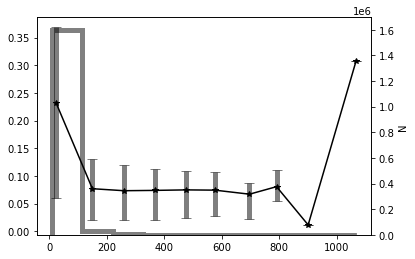

In [80]:
fig, ax=plt.subplots()
plot_quantiles(abs(dfs[0]['zenith_res']), dfstats['n_doms'], 10, np.array([16,50,68]), ax, 'hristian', 'k', 0)

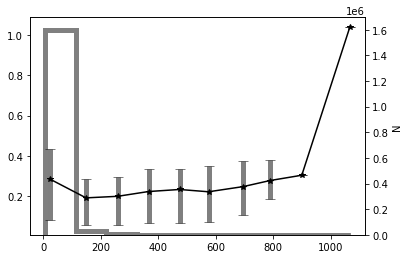

In [81]:
fig, ax=plt.subplots()
plot_quantiles(abs(dfs[3]['zenith_res']), dfstats['n_doms'], 10, np.array([16,50,68]), ax, 'hristian', 'k', 0)

In [82]:

colors=['#F7996E', '#20A4F3', '#519872', '#712F79', 'k', 'r']


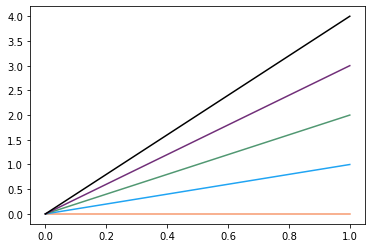

In [83]:
for i in range(5):
    plt.plot([0,i], c=colors[i])

In [84]:
def perc(dfs, res=True):
    return 1
    
def performance(dfs, names=names, offset=0, colors=colors, scale=180/np.pi, unit='degree', ran=[0,80], trueran=[0,180], ab=True, dfx=dfstats, y_param='zenith', logy=False, x_param='n_doms', bins=20, binhist=100, logx=True, qs=[16,50,68]):
    qs=np.array(qs)
    if logx:
        x=np.log(dfx[x_param].to_numpy())
    else:
        x=dfx[x_param].to_numpy()
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xs = np.zeros(bins)
    
    fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))
    axesback=[0]
    for i in axesback:
        a_ = ax[i].twinx()
        a_.hist(x, color = "gray", histtype='step', zorder = 10, alpha = 0.6)
        a_.set_yscale("log")
        if logx:
            ax[0].set_xlabel('log_'+x_param)
            a_.set_ylabel("N/"+'log('+x_param+')')
        else:
            a_.set_xlabel(x_param)
            ax[0].set_ylabel("N/"+x_param)

    for j in range(len(dfs)):
        res=dfs[j][y_param+'_res'].to_numpy()*scale
        if ab:
            res=abs(res)
        for i in tqdm(range(bins)):
            mask = (x >= slices[i])&(x <= slices[i+1])
            if mask.sum() != 0:
                quantiles[i] = np.quantile(res[mask],qs/100)
                xs[i] = np.mean(x[mask])
            else:
                print('whoops',i)
                quantiles[i] = None
                xs[i] = None
        
        ax[0].errorbar(xs+(j-len(dfs))*offset, quantiles[:,1],yerr = quantiles[:,[0,2]].T, fmt=colors[j], marker='.',\
                       capsize=2,linewidth=1,ecolor=colors[j],label=r'[16,50,68]'+'_'+names[j])
        if logx:
            ax[0].set_title(f'{y_param} as a function of log({x_param})')
        else:
            ax[0].set_title(f'{y_param} as a function of {x_param}')
        if logx:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/log({y_param})')
        else:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/{y_param}')
        ax[1].hist(res, label = y_param+'_res_'+names[j], color=colors[j], range=ran, histtype = "step", bins = binhist)
        ax[1].set(xlabel='Residuals'+f'({unit})', ylabel=f'N/{unit}', title='Residuals for '+y_param)
        ax[2].hist(dfs[j][y_param+'_pred']*scale, color=colors[j], range=trueran, histtype = "step", bins = binhist)
        ax[2].set(xlabel='Distribution'+f'({unit})', ylabel=f'N/{unit}', title='Distributions of '+y_param)
        if j==2:
            ax[2].hist(dfjbs[y_param]*scale, label = 'True', color='r', histtype = "step", bins = binhist)
#             ax[2].hist(df[y_param]*scale, label = 'True', color='r', histtype = "step", bins = binhist)
        if logy:
            ax[1].set(yscale='log')
            ax[2].set(yscale='log')
        for a in ax:
            a.legend()
    fig.suptitle(f'{y_param} analysis')
    fig.tight_layout()
    plt.savefig(f'../../figs_thesis/compare_{x_param}_{y_param}.pdf')
    return fig, ax

No handles with labels found to put in legend.


No handles with labels found to put in legend.


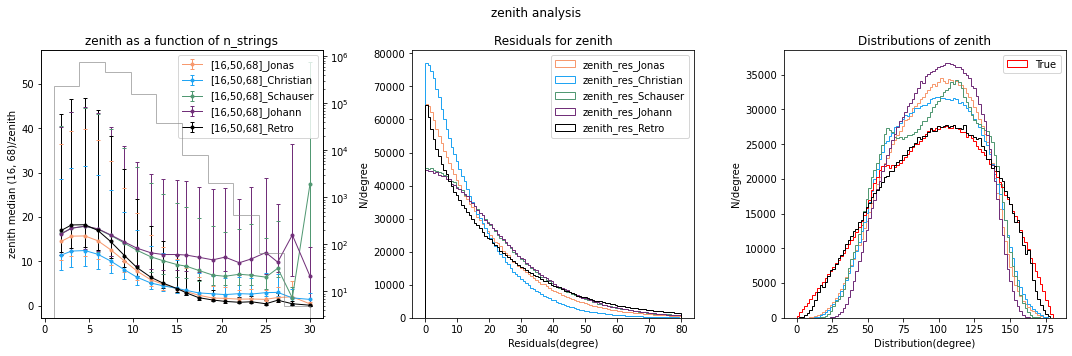

In [85]:
fig,ax=performance(dfs[:5], offset=0, logx=False, x_param='n_strings')

No handles with labels found to put in legend.


No handles with labels found to put in legend.


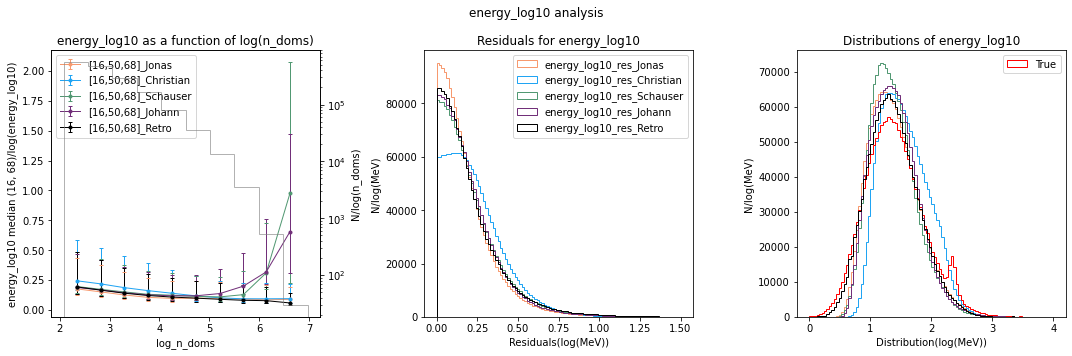

In [86]:
fig,ax=performance(dfs[:5], y_param='energy_log10', bins=10, x_param='n_doms', scale=1, logx=True, unit='log(MeV)', ran=[0,1.5], trueran=[0,4])

In [88]:
# sele=[0,1,2,4]
# performance(dfs[sele], names=names[sele], colors[sele], dfx=)

In [90]:
def performance_cuts(dfs, names=names, dfcuts=dfs, colors=colors, cut_param='zenith_sig', cutp=50, offset=0, scale=180/np.pi, unit='degree', ran=[0,80], trueran=[0,180], ab=True, dfx=dfstats, y_param='zenith', logy=False, x_param='n_doms', bins=20, binhist=100, logx=True, qs=[16,50,68]):
    qs=np.array(qs)
    if logx:
        x=np.log(dfx[x_param].to_numpy())
    else:
        x=dfx[x_param].to_numpy()
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xs = np.zeros(bins)
    
    fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))
    axesback=[0]
    for i in axesback:
        a_ = ax[i].twinx()
        a_.hist(x, color = "gray", histtype='step', zorder = 10, alpha = 0.6)
        a_.set_yscale("log")
        if logx:
            ax[0].set_xlabel('log_'+x_param)
            a_.set_ylabel("N/"+'log('+x_param+')')
        else:
            a_.set_xlabel(x_param)
            ax[0].set_ylabel("N/"+x_param)
    
    for j in range(len(dfs)):
        dfcuts[j][cut_param]
        maskcut=dfcuts[j][cut_param].to_numpy()<np.percentile(dfcuts[j][cut_param],[cutp])
        print(f'Cutting at {cut_param} {np.percentile(dfcuts[j][cut_param],[cutp])}')
        df=dfs[j][maskcut]
        x0=x[maskcut]
        res=df[y_param+'_res'].to_numpy()*scale
        if ab:
            res=abs(res)
        for i in tqdm(range(bins)):
            mask = (x0 >= slices[i])&(x0 <= slices[i+1])
            if mask.sum() != 0:
                quantiles[i] = np.quantile(res[mask],qs/100)
                xs[i] = np.mean(x0[mask])
            else:
                print('whoops',i)
                quantiles[i] = None
                xs[i] = None
        
        ax[0].errorbar(xs+(j-len(dfs))*offset, quantiles[:,1],yerr = quantiles[:,[0,2]].T, fmt=colors[j], marker='.',\
                       capsize=2,linewidth=1,ecolor=colors[j],label=r'[16,50,68]'+'_'+names[j])
        if logx:
            ax[0].set_title(f'{y_param} as a function of log({x_param})')
        else:
            ax[0].set_title(f'{y_param} as a function of {x_param}')
        if logx:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/log({y_param})')
        else:
            ax[0].set_ylabel(f'{y_param} median (16, 68)/{y_param}')
        ax[1].hist(res, label = y_param+'_res_'+names[j], color=colors[j], range=ran, histtype = "step", bins = binhist)
        ax[1].set(xlabel='Residuals'+f'({unit})', ylabel=f'N/{unit}', title='Residuals for '+y_param)
        ax[2].hist(df[y_param+'_pred']*scale, color=colors[j], range=trueran, histtype = "step", bins = binhist)
        ax[2].set(xlabel='Distribution'+f'({unit})', ylabel=f'N/{unit}', title='Distributions of '+y_param)
        if j==0:
            ax[2].hist(dfs[j][y_param]*scale, label = 'True', color='r', histtype = "step", bins = binhist)
        if logy:
            ax[1].set(yscale='log')
            ax[2].set(yscale='log')
        for a in ax:
            a.legend()
    fig.suptitle(f'{y_param} analysis with {cut_param} cut')
    fig.tight_layout()
    plt.savefig(f'../../figs_thesis/compare_{x_param}_{y_param}_cut_{cut_param}_{cutp}.pdf')
    return fig, ax

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of log(n_doms)'}, xlabel='log_n_doms', ylabel='zenith median (16, 68)/log(zenith)'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

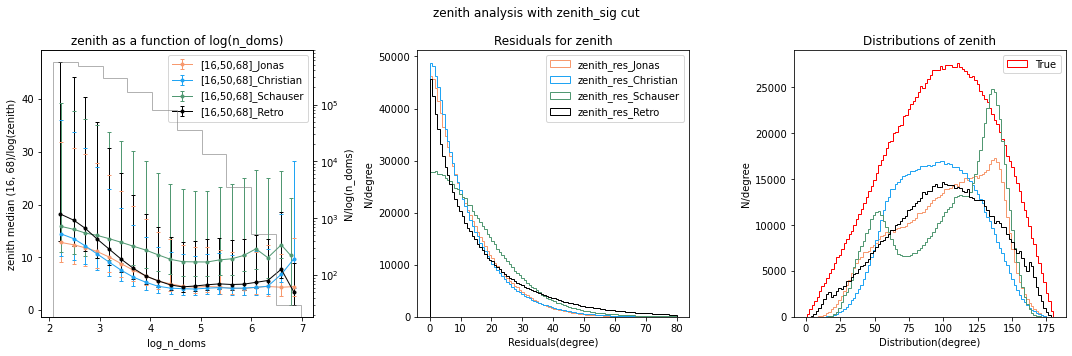

In [91]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], dfx=dfstats,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of n_strings'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

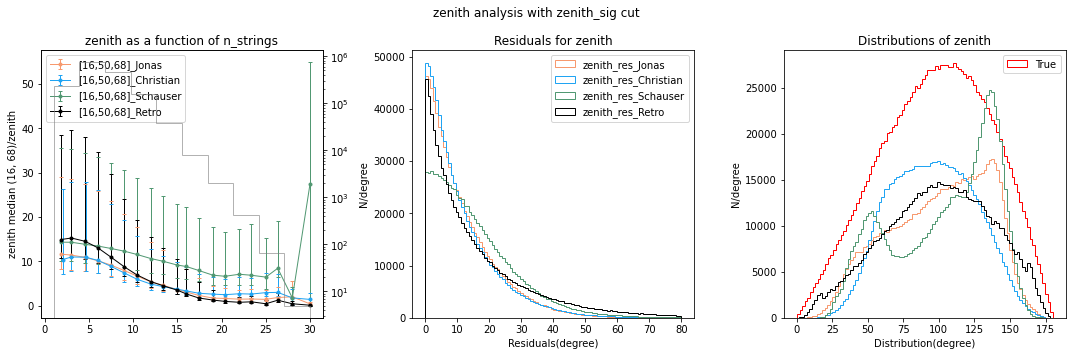

In [92]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='n_strings',dfx=dfstats,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

Cutting at zenith_sig [0.16766521]


whoops 0

Cutting at zenith_sig [0.35472054]


whoops 0
whoops 1

Cutting at zenith_sig [0.29025556]


whoops 0

Cutting at zenith_sig [0.07513809]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of energy_log10'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

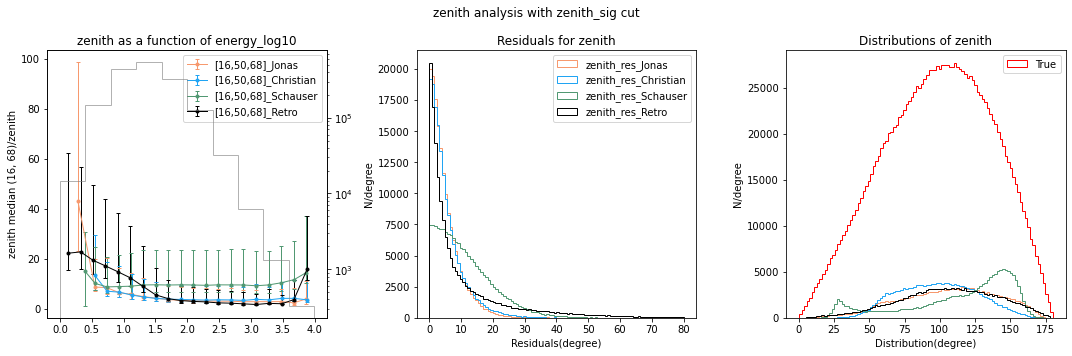

In [93]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='energy_log10',
                 dfx=df_truth,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]], cutp=10)

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of zenith'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

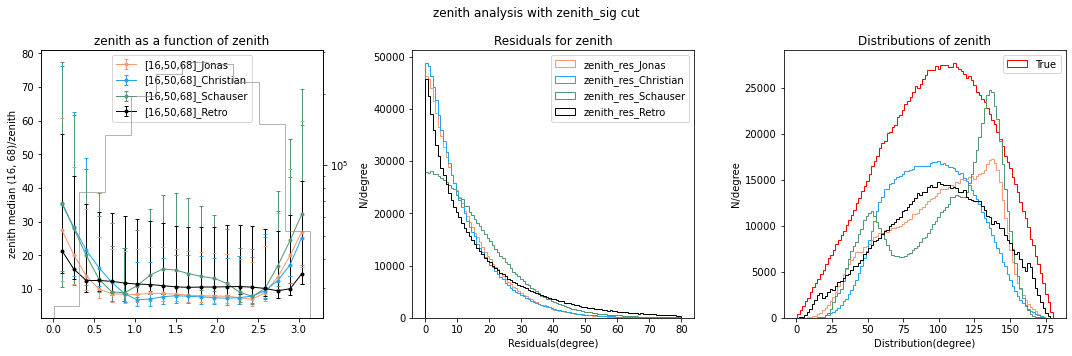

In [94]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='zenith',
                 dfx=df_truth,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

Cutting at zenith_sig [0.36070742]



Cutting at zenith_sig [0.91162231]



Cutting at zenith_sig [0.43032089]



Cutting at zenith_sig [0.2986238]


(<Figure size 1080x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'zenith as a function of zenith'}, ylabel='zenith median (16, 68)/zenith'>,
        <AxesSubplot:title={'center':'Residuals for zenith'}, xlabel='Residuals(degree)', ylabel='N/degree'>,
        <AxesSubplot:title={'center':'Distributions of zenith'}, xlabel='Distribution(degree)', ylabel='N/degree'>],
       dtype=object))

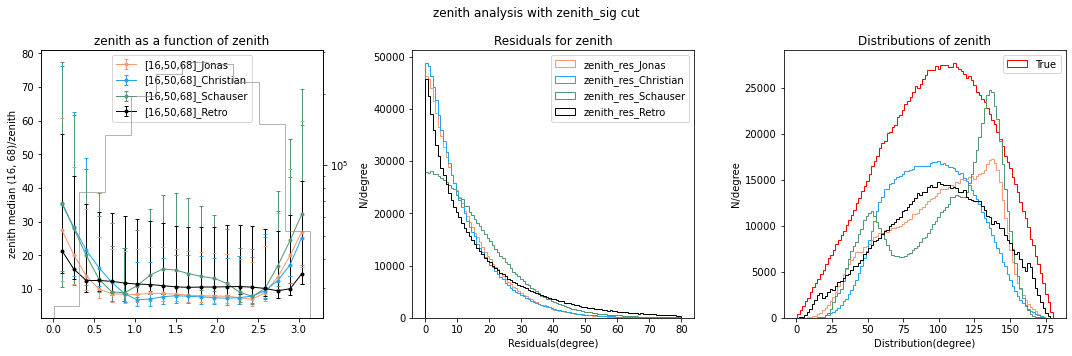

In [95]:
performance_cuts([dfs[0], dfs[1], dfs[2], dfs[4]], dfcuts=[dfs[0], dfs[1], dfs[2], dfs[4]], logx=False, x_param='zenith',
                 dfx=df_truth,\
                 names=names[:3]+[names[4]], colors=colors[:3]+[colors[4]])

No handles with labels found to put in legend.


No handles with labels found to put in legend.


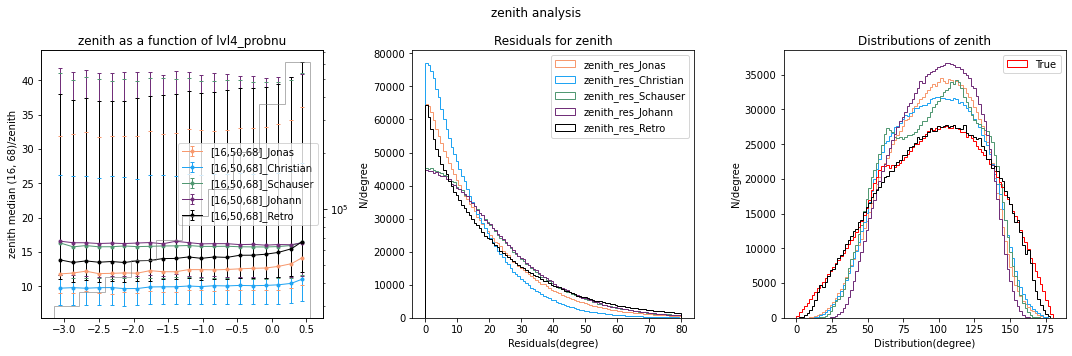

In [96]:
fig,ax=performance(dfs[:5], y_param='zenith', bins=20, x_param='lvl4_probnu', logx=0, dfx=df_truth)

whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9


No handles with labels found to put in legend.


whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9


No handles with labels found to put in legend.


whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9



whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9



whoops 1
whoops 2
whoops 3
whoops 4
whoops 5
whoops 6
whoops 7
whoops 8
whoops 9



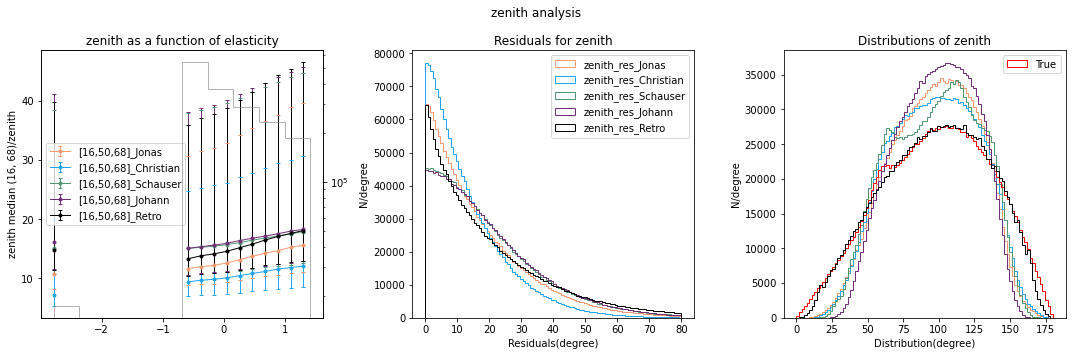

In [97]:
fig,ax=performance(dfs[:5], y_param='zenith', bins=20, x_param='elasticity', logx=0, dfx=df_truth)

<AxesSubplot:>

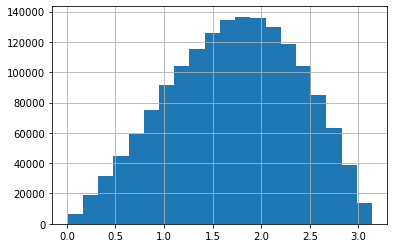

In [98]:
df_truth['zenith'].hist(bins=20)

<AxesSubplot:>

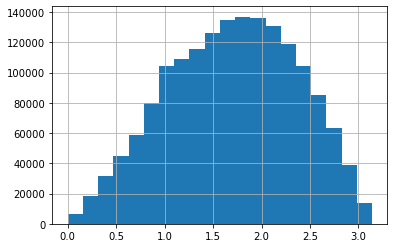

In [99]:
dfjs['zenith'].hist(bins=20)

In [ ]:
dfjs['zenith'].hist(bins=20)